In [ ]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'CS231N/assignments/assignment2/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Mounted at /content/drive
/content/drive/My Drive/CS231N/assignments/assignment2/cs231n/datasets
/content


# Dropout
Dropout [1] — это метод регуляризации нейронных сетей путем случайного обнуления некоторых выходных активаций во время прямого прохода. В этом упражнении вы реализуете слой dropout и измените свою полносвязную сеть, чтобы при необходимости использовать dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [ ]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout forward pass
В файле `cs231n/layers.py` реализуйте прямой проход для dropout. Поскольку отсев ведет себя по-разному во время обучения и тестирования, обязательно реализуйте операцию для обоих режимов.

После этого запустите ячейку ниже, чтобы проверить свою реализацию.

In [ ]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



# Dropout backward pass

В файле `cs231n/layers.py` реализуйте обратный проход для dropout. После этого запустите следующую ячейку, чтобы численно проверить градиент вашей реализации.

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:

Что произойдет, если мы не разделим значения, проходящие через inverse dropout, на `p` в слое dropout? Почему это происходит?

## Answer:
В сетях с dropout во время обучения нейроны остаются активны  с вероятностью `p`, а выход остальных обнуляется,  то есть они не учавствуют в обучении и их веса не обновляются. Оставшаяся подсеть из активных нейронов обучается на введенных данных. После в уже обученной сети не производится отбрасывание нейронов и в вычислениях учавствуют все нейроны. При работе уже обученной сети масштабируются выходы всех нейронов на `p` - это так называемое приближенное усреднение, которое выполняется для усреднения выводов обученных нейронов, которые были частью разных `2^N` подсетей. Выполняя это масштабирование, `2^N` сетей с общими весами можно объединить таким приближенным усреднением в единую нейронную сеть.

Рассмотрим мат ожидание выхода - `y` нейрона  при обучении: `E[y] = py + (1-p)0 = py`, где `p` - вероятность того что нейрон будет активирован. Тогда ожидаемый выход нейрона на тестовой выборке будет `E[y] = y`.
Чтобы на тестовой выборке обеспечить такое же среднее выходов нейронов, как и при обучении нужно масштабировать выходы каждого нейрона на `p`: `E[y^] = py`. В случае варианта реализации `inverse dropout` не нужно масштабировать выходы нейронов после обучения, а нужно масштабировать выходы нейронов во время обучения на `1/p`. Тогда средний ожидаемый выход нейрона во время обучения `E[y] = p*y/p + (1-p)*0/p = y`. И средний ожидаемый выход нейрона во время тестирования `E[y^] = y`. Без масштабирования выходов нейронов при обучении в случае `inverse dropout` или после обучения в случае `обычного dropout` окажется, что распределения значений выходов нейронов не будут соответствовать по масштабу ожидаемым распределениям входов нейронов следующего уровня, на которых они были обучены. Соответсвтенно ожидать эффективности работы обученной нейросети на тестовых данных не стоит. К тому же без масштабирования выходов в том или ином случае описанном выше, не будет так называемого приближенного усреднения результатов всевозможных обученный `2^N` подсетей. 




# Fully-connected nets with Dropout
В файле `cs231n/classifiers/fc_net.py` измените свою реализацию, чтобы использовать отсев (dropout). В частности, если конструктор сети получает значение, отличное от 1, для параметра `dropout`, то сеть должна добавлять слой отсева сразу после каждой нелинейности ReLU. После этого запустите следующее, чтобы численно проверить градиент вашей реализации.

In [ ]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



# Regularization experiment

В качестве эксперимента мы обучим пару двухслойных сетей на 500 обучающих примерах: одна будет без dropout, а другая будет использовать вероятность сохранения 0.25. Затем мы визуализируем точность обучения и точность на валидационной выборке двух сетей с течением времени.

In [ ]:
# Train two identical nets, one with dropout and one without
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [1, 0.25]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver
  print()

1
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.260000; val_acc: 0.184000
(Epoch 1 / 25) train acc: 0.416000; val_acc: 0.258000
(Epoch 2 / 25) train acc: 0.482000; val_acc: 0.276000
(Epoch 3 / 25) train acc: 0.532000; val_acc: 0.277000
(Epoch 4 / 25) train acc: 0.600000; val_acc: 0.271000
(Epoch 5 / 25) train acc: 0.708000; val_acc: 0.299000
(Epoch 6 / 25) train acc: 0.722000; val_acc: 0.282000
(Epoch 7 / 25) train acc: 0.832000; val_acc: 0.255000
(Epoch 8 / 25) train acc: 0.880000; val_acc: 0.268000
(Epoch 9 / 25) train acc: 0.902000; val_acc: 0.277000
(Epoch 10 / 25) train acc: 0.898000; val_acc: 0.261000
(Epoch 11 / 25) train acc: 0.924000; val_acc: 0.263000
(Epoch 12 / 25) train acc: 0.960000; val_acc: 0.300000
(Epoch 13 / 25) train acc: 0.972000; val_acc: 0.314000
(Epoch 14 / 25) train acc: 0.972000; val_acc: 0.312000
(Epoch 15 / 25) train acc: 0.974000; val_acc: 0.315000
(Epoch 16 / 25) train acc: 0.994000; val_acc: 0.304000
(Epoch 17 / 25) train acc: 0.974000; v

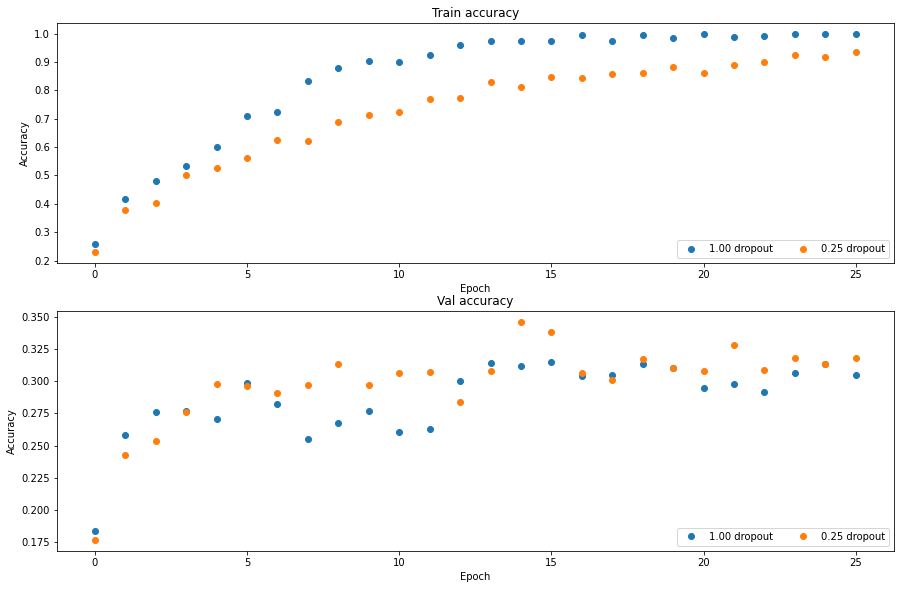

In [ ]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Inline Question 2:

Сравните точность проверки и обучения с отсевом и без него — что говорят ваши результаты об отсеве как регуляризаторе?

## Answer:
Если сравнивать точность двух сетей на обучающей выборке. То для одной и той же по номеру эпохи точность сети с dropout меньше чем без него. Так уже на 16 эпохе сеть без отсева достигает около 99% а с отсевом 84% точности.

Видо что с dropout сеть обучается медленнее, так как каждый раз для новой порции данных для обучения из всей сети выбирается случайно подсеть в среднем с np = 500*0.25 = 125 (мат. ожидание с.в. распределенной по биномиальному закону распределения) скрытыми нейронами. И к тому же каждая из 2^N сетей обучается очень редко если вообще обучается.

Сеть с dropout на валидационной выборке показывает точность чуть лучше, чем сеть без него. Dropout позволяет значительно уменьшить возможность переобучения используемой сети (если не выбирать p близким к 1). Каждый раз обучается подсеть с случайно  выбранными нейронами. То есть во время обучения нейроны обучаются в разных подсетях. Это способствует уменьшению коадаптации нейронов, которые совместно подстраиваются под данные обучения, но при этом может быть, что ошибка на одном нейроне компинсируется результатами других. В таком случае на обучающих данных ошибки будут минимальны, но на новых тестовых данных, которые сеть не видела, результаты будут значительно хуже – это переобучение. С Dropout нейроны состоят каждый раз в связях с новым множеством нейронов. Нейрон стимулируется вырабатывать полезные признаки, имеющие значения конкретно для этого нейрона. Dropout в значительной степень уменьшает возможность переобучения и позволяет увеличить эффективность сети.



## Inline Question 3:

Предположим, мы обучаем глубокую полносвязную сеть для классификации изображений с отсевом после скрытых слоев (параметризованных вероятностью сохранения p). Если нас беспокоит переобучение, как нам изменить p (если вообще изменить), когда мы решим уменьшить размер скрытых слоев (то есть количество узлов в каждом слое)?

## Answer:
Среднее кол-во скрытых нейронов в подсетях при обучении с dropout = np, n - кол-во нейронов, p - вероятность того что нейрон будет активен. Контролировать среднее кол-во активных нейронов при обучении можно изменяя как кол-во скрытых нейронов, так и параметр p. Чем меньше подсеть, тем меньше её репрезентативная сила, и может оказаться, что сложности подсетей не хватает, чтобы обучиться на даных. Но и излишне большие подсети погут привести к переобучению.

В нашем случае имеется сеть с dropout и беспокоит переобучение. Значит, нам нужно уменьшить репрезентативную силу обучаемых подсетей, то есть уменьшить среднее кол-во обучаемых нейронов. Это можно сделать, уменьшив как параметр p, так и уменьшив размер скрытых слоев. Так как принято решение уменьшить размер скрытых слоев, то это уже уменьшит среднее кол-во нейронов учавствующих в обучении. И тогда следует оставить параметр p неизменным. 

Если сеть БЕЗ dropout достигла хороших результатов при n скрытых нейронах, то с использованием dropout с вероятностью активации p сеть должна иметь минимум n/p скрытых нейронов для того, чтобы не уменьшать репрезентативную силу подсетей.




